# PCM Modeling

In this section of the tutorial, we will use the knowledge from all previous tutorials to construct a simple PCM classification model for a small list of adenosine receptors.

## Data Preparation

Most of the data preparation steps are already provided in  [data_preparation_advanced](./data_preparation_advanced.ipynb) so we will again use an already prepared dataset from the `datasets.py` module:

In [1]:
from datasets import AR_PCM

ds = AR_PCM()
print(ds.proteincol)
print(ds.proteinseqprovider)
print(len(ds))
print(ds.targetProperties)
ds.getDF()

########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 3
Total size: 33.0MB


Using existing data from data\AR_LIGANDS.tsv...
########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 3
Total size: 33.0MB


accession
<function AR_PCM.<locals>.sequence_provider at 0x00000207730EBF40>
12440
[TargetProperty(name=pchembl_value_Median_class, task=SINGLECLASS, th=[6.5])]


,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD,QSPRID,pchembl_value_Median_class
QSPRID,,,,,,,,,,,,,,,,,,,,,
AR_LIGANDS_0,AACWUFIIMOHGSO_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.91968,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,AACWUFIIMOHGSO,AACWUFIIMOHGSO-UHFFFAOYSA-N,InChI=1S/C19H24N6O2/c1-12-10-13(2)25(23-12)17-...,"""AuxInfo=1/1/N:1,26,22,14,15,20,19,11,12,27,6,...",P29274_WT,...,=,8.68,8.680,0.000000,0.000000,1.0,8.680,0.000,AR_LIGANDS_0,True
AR_LIGANDS_1,AACWUFIIMOHGSO_on_P30542_WT,High,ChEMBL31,ChEMBL31.compound.91968,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,AACWUFIIMOHGSO,AACWUFIIMOHGSO-UHFFFAOYSA-N,InChI=1S/C19H24N6O2/c1-12-10-13(2)25(23-12)17-...,"""AuxInfo=1/1/N:1,26,22,14,15,20,19,11,12,27,6,...",P30542_WT,...,=,6.68,6.680,0.000000,0.000000,1.0,6.680,0.000,AR_LIGANDS_1,True
AR_LIGANDS_2,AAEYTMMNWWKSKZ_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.131451,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,AAEYTMMNWWKSKZ,AAEYTMMNWWKSKZ-UHFFFAOYSA-N,InChI=1S/C18H16N4O3S/c19-15-13-9-10-3-1-2-4-14...,"""AuxInfo=1/1/N:22,23,21,24,8,15,9,14,19,20,7,1...",P29274_WT,...,=,4.82,4.820,0.000000,0.000000,1.0,4.820,0.000,AR_LIGANDS_2,False
AR_LIGANDS_3,AAGFKZWKWAMJNP_on_P0DMS8_WT,High,ChEMBL31,ChEMBL31.compound.100375,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,AAGFKZWKWAMJNP,AAGFKZWKWAMJNP-UHFFFAOYSA-N,InChI=1S/C21H14N6O2/c28-20(14-8-3-1-4-9-14)24-...,"""AuxInfo=1/1/N:27,19,26,28,18,20,9,25,29,17,21...",P0DMS8_WT,...,=,7.15,7.150,0.000000,0.000000,1.0,7.150,0.000,AR_LIGANDS_3,True
AR_LIGANDS_4,AAGFKZWKWAMJNP_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.100375,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,AAGFKZWKWAMJNP,AAGFKZWKWAMJNP-UHFFFAOYSA-N,InChI=1S/C21H14N6O2/c28-20(14-8-3-1-4-9-14)24-...,"""AuxInfo=1/1/N:27,19,26,28,18,20,9,25,29,17,21...",P29274_WT,...,=,5.65,5.650,0.000000,0.000000,1.0,5.650,0.000,AR_LIGANDS_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AR_LIGANDS_12435,ZXPDGTGMZKIESV_on_P29274_WT,High,ChEMBL31,ChEMBL31.compound.49348;ChEMBL31.compound.413675,CNC(=O)C12CC1C(n1cnc3c1nc(Cl)nc3NC1CCCC1)C(O)C2O,ZXPDGTGMZKIESV,ZXPDGTGMZKIESV-UHFFFAOYSA-N,InChI=1S/C18H23ClN6O3/c1-20-16(28)18-6-9(18)11...,"""AuxInfo=1/1/N:1,22,23,21,24,6,10,20,7,12,8,25...",P29274_WT,...,=,5.49;5.49,5.490,0.000000,0.000000,2.0,5.490,0.000,AR_LIGANDS_12435,False
AR_LIGANDS_12436,ZXPDGTGMZKIESV_on_P30542_WT,High,ChEMBL31,ChEMBL31.compound.49348;ChEMBL31.compound.413675,CNC(=O)C12CC1C(n1cnc3c1nc(Cl)nc3NC1CCCC1)C(O)C2O,ZXPDGTGMZKIESV,ZXPDGTGMZKIESV-UHFFFAOYSA-N,InChI=1S/C18H23ClN6O3/c1-20-16(28)18-6-9(18)11...,"""AuxInfo=1/1/N:1,22,23,21,24,6,10,20,7,12,8,25...",P30542_WT,...,=,7.74;7.74,7.740,0.000000,0.000000,2.0,7.740,0.000,AR_LIGANDS_12436,True
AR_LIGANDS_12437,ZYEXHNHGCDESIU_on_P0DMS8_WT,High,ChEMBL31,ChEMBL31.compound.1825,Nc1c2nc(C#Cc3ccccc3)n(C3OC(CO)C(O)C3O)c2ncn1,ZYEXHNHGCDESIU,ZYEXHNHGCDESIU-UHFFFAOYSA-N,InChI=1S/C18H17N5O4/c19-16-13-17(21-9-20-16)23...,"""AuxInfo=1/1/N:11,10,12,9,13,7,6,18,26,8,17,5,...",P0DMS8_WT,...,=,6.07;6.1,6.085,0.021213,0.015000,2.0,6.085,0.015,AR_LIGANDS_12437,False


The only difference between PCM and regular models is the need for protein descriptors. Adding them is as simple as adding a `ProteinDescriptorCalculator` to the list of calculators in the call to `prepareDataset`:

In [2]:
from qsprpred.data.utils.datasplitters import randomsplit
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from qsprpred.extra.data.utils.descriptorcalculator import ProteinDescriptorCalculator
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.extra.data.utils.descriptorsets import ProDecDescriptorSet
from qsprpred.extra.data.utils.descriptor_utils.msa_calculator import ClustalMSA

calc_prot = ProteinDescriptorCalculator(
    descsets=[ProDecDescriptorSet(sets=["Zscale Hellberg"])],
    msa_provider=ClustalMSA(out_dir=ds.storeDir)
)
calc_mol = MoleculeDescriptorsCalculator(descsets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

ds.prepareDataset(
    split=randomsplit(0.2), # note that this is only for illustration and using a random split like this is usually not a good idea in PCM
    feature_calculators=[calc_prot, calc_mol]
)

ApplicationError: Non-zero return code 1 from 'clustalo -i data/sequences.fasta -o data/alignment.aln-fasta.fasta --outfmt fasta --auto -v --force', message "'clustalo' is not recognized as an internal or external command,"

In [3]:
ds.getFeatures()[0] # training set feature matrix

,Descriptor_PCM_ProDec_Zscale_1,Descriptor_PCM_ProDec_Zscale_2,Descriptor_PCM_ProDec_Zscale_3,Descriptor_PCM_ProDec_Zscale_4,Descriptor_PCM_ProDec_Zscale_5,Descriptor_PCM_ProDec_Zscale_6,Descriptor_PCM_ProDec_Zscale_7,Descriptor_PCM_ProDec_Zscale_8,Descriptor_PCM_ProDec_Zscale_9,Descriptor_PCM_ProDec_Zscale_10,...,Descriptor_FingerprintSet_MorganFP_2038,Descriptor_FingerprintSet_MorganFP_2039,Descriptor_FingerprintSet_MorganFP_2040,Descriptor_FingerprintSet_MorganFP_2041,Descriptor_FingerprintSet_MorganFP_2042,Descriptor_FingerprintSet_MorganFP_2043,Descriptor_FingerprintSet_MorganFP_2044,Descriptor_FingerprintSet_MorganFP_2045,Descriptor_FingerprintSet_MorganFP_2046,Descriptor_FingerprintSet_MorganFP_2047
QSPRID,,,,,,,,,,,,,,,,,,,,,
AR_LIGANDS_3866,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_2625,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.49,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_9043,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_9068,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_5743,-2.49,-0.27,-0.41,-1.22,0.88,2.23,3.22,1.45,0.84,3.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AR_LIGANDS_9622,-2.49,-0.27,-0.41,-1.22,0.88,2.23,3.22,1.45,0.84,3.22,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_11103,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_6625,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ds.getFeatures()[1] # test set feature matrix

,Descriptor_PCM_ProDec_Zscale_1,Descriptor_PCM_ProDec_Zscale_2,Descriptor_PCM_ProDec_Zscale_3,Descriptor_PCM_ProDec_Zscale_4,Descriptor_PCM_ProDec_Zscale_5,Descriptor_PCM_ProDec_Zscale_6,Descriptor_PCM_ProDec_Zscale_7,Descriptor_PCM_ProDec_Zscale_8,Descriptor_PCM_ProDec_Zscale_9,Descriptor_PCM_ProDec_Zscale_10,...,Descriptor_FingerprintSet_MorganFP_2038,Descriptor_FingerprintSet_MorganFP_2039,Descriptor_FingerprintSet_MorganFP_2040,Descriptor_FingerprintSet_MorganFP_2041,Descriptor_FingerprintSet_MorganFP_2042,Descriptor_FingerprintSet_MorganFP_2043,Descriptor_FingerprintSet_MorganFP_2044,Descriptor_FingerprintSet_MorganFP_2045,Descriptor_FingerprintSet_MorganFP_2046,Descriptor_FingerprintSet_MorganFP_2047
QSPRID,,,,,,,,,,,,,,,,,,,,,
AR_LIGANDS_7033,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_683,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_8622,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_9335,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_3561,-2.49,-0.27,-0.41,-1.22,0.88,2.23,3.22,1.45,0.84,3.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AR_LIGANDS_10868,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_9240,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_LIGANDS_8960,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [5]:
ds.save() # save for later

## Model Construction

Now that we have defined our preprocessing steps, we can construct our model. We will use a simple random forest model in this case, but notice that the training code is allmost the same as in the simple [training tutorial](./tutorial_training.ipynb). The only difference is that we are using the `QSPRsklearnPCM` class instead of `QSPRsklearn`:

In [6]:
from sklearn.ensemble import RandomForestClassifier
from qsprpred.extra.models.pcm import QSPRsklearnPCM
from qsprpred.models.param_optimization import OptunaOptimization

model = QSPRsklearnPCM(base_dir = '.', data=ds, alg = RandomForestClassifier, name='PCM_RF')

params = {
    'n_estimators' : [50, 100],
    "n_jobs": [1]
}

bayesoptimizer = OptunaOptimization(scoring = model.score_func, param_grid=params, n_trials=2)
best_params = bayesoptimizer.optimize(model)
model.saveParams(best_params)

_ = model.evaluate()
model.fit()

[I 2023-05-14 18:17:47,041] A new study created in memory with name: no-name-c586edf4-3321-46ce-a2ad-bca471e3702c


Bayesian optimization can take a while for some hyperparameter combinations
{}


[I 2023-05-14 18:18:20,105] Trial 0 finished with value: 0.8954895647229231 and parameters: {}. Best is trial 0 with value: 0.8954895647229231.


{}


[I 2023-05-14 18:18:52,925] Trial 1 finished with value: 0.8947016606686499 and parameters: {}. Best is trial 0 with value: 0.8954895647229231.
/home/sichom/projects/QSPRpred/qsprpred/models/models.py:71: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(**fit_set)


The `QSPRsklearnPCM` class is a subclass of `QSPRsklearn` and thus inherits all of its functionality. The only difference is in how it handles predictions, which we will [show later](#model-prediction). Model evaluation and plotting is also the same as in the [training tutorial](./tutorial_training.ipynb):

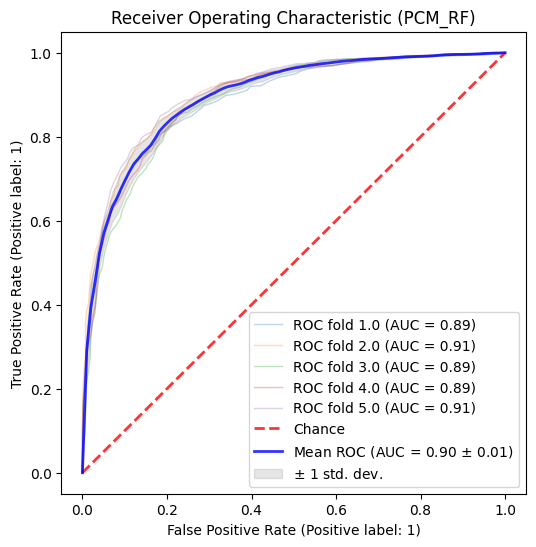

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [7]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make("pchembl_value_Median_class", 'cv', save = True, show=True)

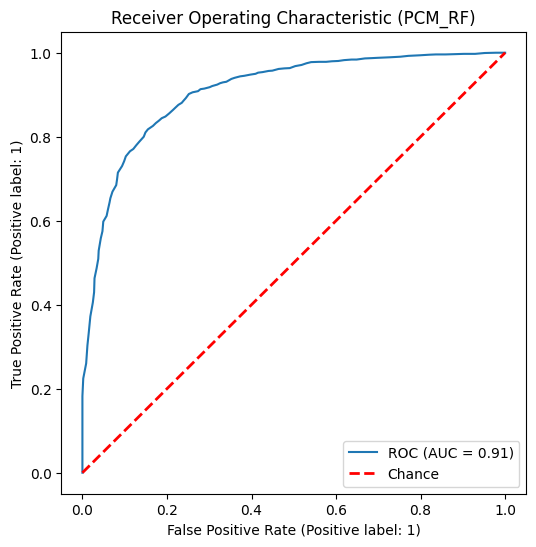

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [8]:
plot.make("pchembl_value_Median_class", 'ind', save = True, show=True)

## Model Prediction

Prediction with the PCM model works similarly to regular models. We can load the saved model using its name (`RF_PCM`) as usual:

In [9]:
model_from_files = QSPRsklearnPCM(name='PCM_RF', base_dir = '.')
model_from_files

But naturally when doing the prediction, we need to provide the protein ID to fetch protein descriptors for as well. You can see that regular call to `predict` now does not work

In [10]:
sample_mols = [
    'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', # caffeine
    'c1ccccc1CCN1N=CC2=C1N=C(N)N3C2=NC(C4=CC=CO4)=N3' # SCH-58261 (50x more selective to A2A than caffeine -> more potent)
]

In [12]:
try:
    model_from_files.predictMols(
        sample_mols
    )
except TypeError as e:
    print(e)

ModelPCM.predictMols() missing 1 required positional argument: 'protein_id'


We need to use one of the protein IDs from the training data to fetch the appropriate protein descriptors:

In [13]:
ds.getSubset(ds.proteincol)[ds.proteincol].unique()

array(['P29274', 'P30542', 'P0DMS8', 'P29275'], dtype=object)

In [14]:
model_from_files.predictMols(
    sample_mols,
    protein_id = 'P29274', # human adenosine A2A receptor
    use_probas=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Missing values filled with nan
/home/sichom/software/miniconda/envs/QSPRpred/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.76, 0.24],
       [0.01, 0.99]])

Now that makes sense. We can see that for the selective compound (`SCH-58261`), the model predicts it as active with confidence. If we use the same compounds with the other isoforms, we can see that indeed the result would be inactive for this compound hinting at its selectivity:

In [15]:
model_from_files.predictMols(
    sample_mols,
    protein_id = 'P30542', # human adenosine A2A receptor
    use_probas=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Missing values filled with nan
/home/sichom/software/miniconda/envs/QSPRpred/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.8 , 0.2 ],
       [0.94, 0.06]])

In [16]:
model_from_files.predictMols(
    sample_mols,
    protein_id = 'P0DMS8', # human adenosine A2A receptor
    use_probas=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Missing values filled with nan
/home/sichom/software/miniconda/envs/QSPRpred/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.61, 0.39],
       [0.93, 0.07]])

In [17]:
model_from_files.predictMols(
    sample_mols,
    protein_id = 'P29275', # human adenosine A2A receptor
    use_probas=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Missing values filled with nan
/home/sichom/software/miniconda/envs/QSPRpred/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.87, 0.13],
       [0.75, 0.25]])